In [19]:
import polars as pl
import pandas as pd
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
base_dir = '../data/processed/grouped/'
files = glob.glob(base_dir + '*')

In [3]:
df = pl.read_parquet('../data/raw/parquet_files/train/train_base.parquet')
for file in files:
    temp_df = pl.read_parquet(file)
    df = df.join(temp_df, how='left', on='case_id')

df = df.drop(['date_decision', 'MONTH'])

for col in df.columns:
    if df[col].dtype == pl.Date:
        df = df.with_columns(pl.col(col).cast(pl.Int64))

In [5]:
case_ids = df['case_id'].unique().shuffle(seed=28).to_list()    # Must be list

In [6]:
def case_ids_to_df(df: pl.DataFrame, case_ids: list) -> tuple[pl.DataFrame]:
    pred_cols = df.drop(['case_id', 'target']).columns
    
    return (
        df.filter(pl.col('case_id').is_in(case_ids))[pred_cols],
        df.filter(pl.col('case_id').is_in(case_ids))['target'].to_pandas()  # Must be numpy 1D Array or pandas Series
    )

In [7]:
case_ids_train, case_ids_val = train_test_split(case_ids, train_size=0.8, random_state=28)
X_train, y_train = case_ids_to_df(df, case_ids_train)
X_val, y_val = case_ids_to_df(df, case_ids_val)

assert X_train.shape[0] + X_val.shape[0] == df.shape[0]

In [8]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)]
)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.7981
[100]	valid_0's auc: 0.816513
[150]	valid_0's auc: 0.824424
[200]	valid_0's auc: 0.829001
[250]	valid_0's auc: 0.831844
[300]	valid_0's auc: 0.834009
[350]	valid_0's auc: 0.835503
[400]	valid_0's auc: 0.836688
[450]	valid_0's auc: 0.837781
[500]	valid_0's auc: 0.838714
[550]	valid_0's auc: 0.839566
[600]	valid_0's auc: 0.840236
[650]	valid_0's auc: 0.840886
[700]	valid_0's auc: 0.841461
[750]	valid_0's auc: 0.841916
[800]	valid_0's auc: 0.842307
[850]	valid_0's auc: 0.842694
[900]	valid_0's auc: 0.842973
[950]	valid_0's auc: 0.843364
[1000]	valid_0's auc: 0.843614
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.843614


In [9]:
pred_cols = df.drop(['case_id', 'target']).columns

In [18]:
feat_imps = gbm.feature_importance()

assert feat_imps.shape[0] == len(pred_cols)

In [25]:
feat_df = pd.DataFrame({'feature': pred_cols, 'importance': feat_imps})
feat_df = feat_df.sort_values(by='importance', ascending=False)

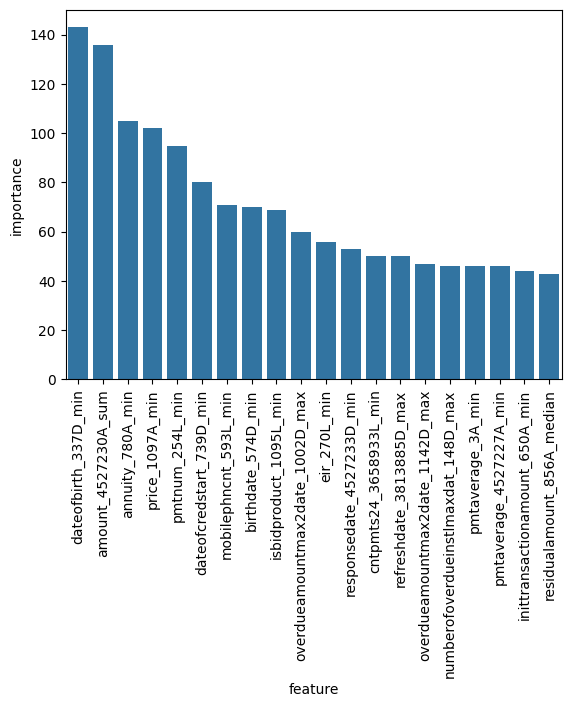

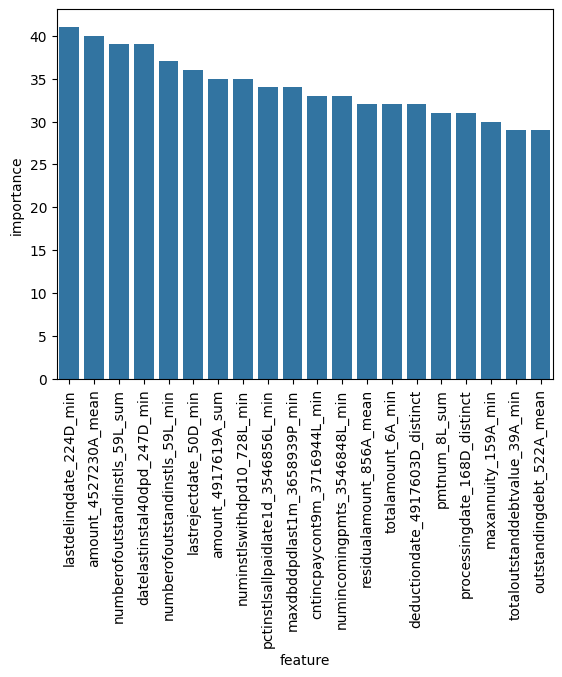

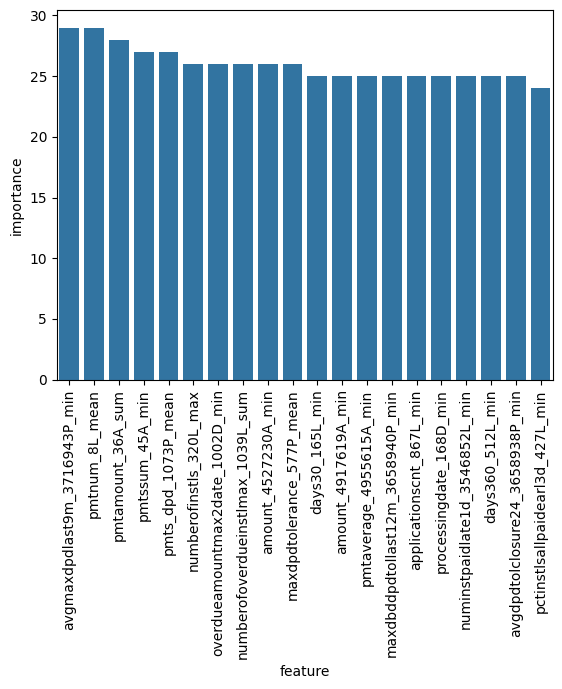

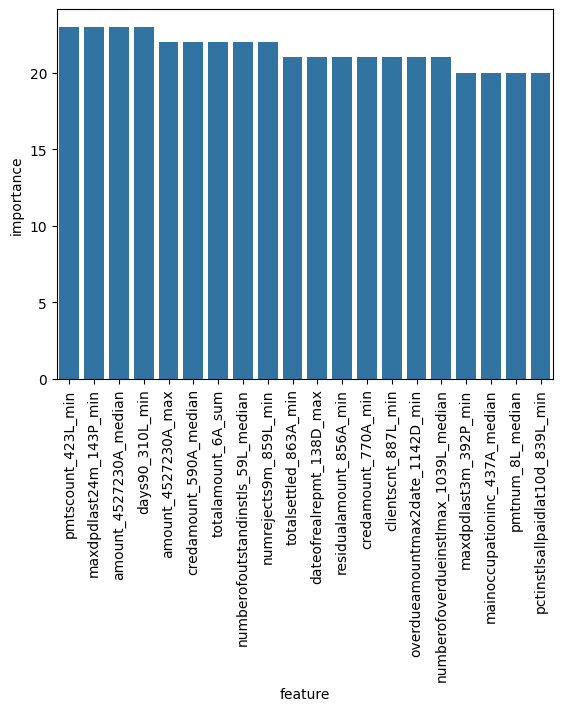

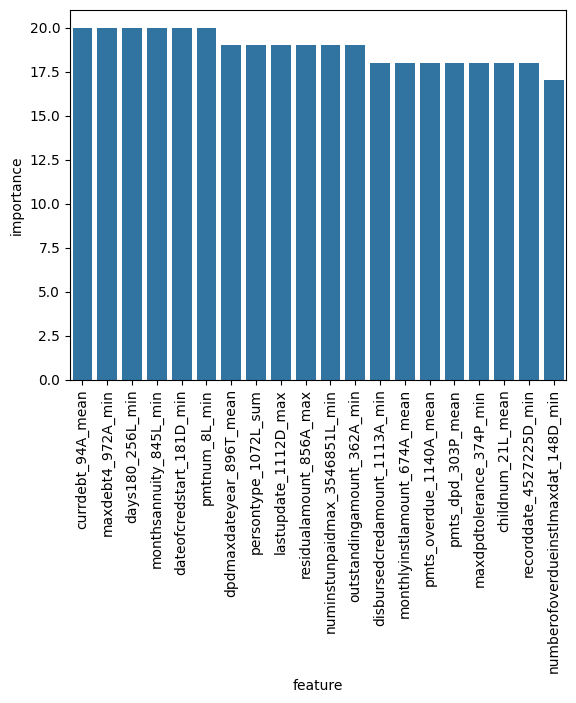

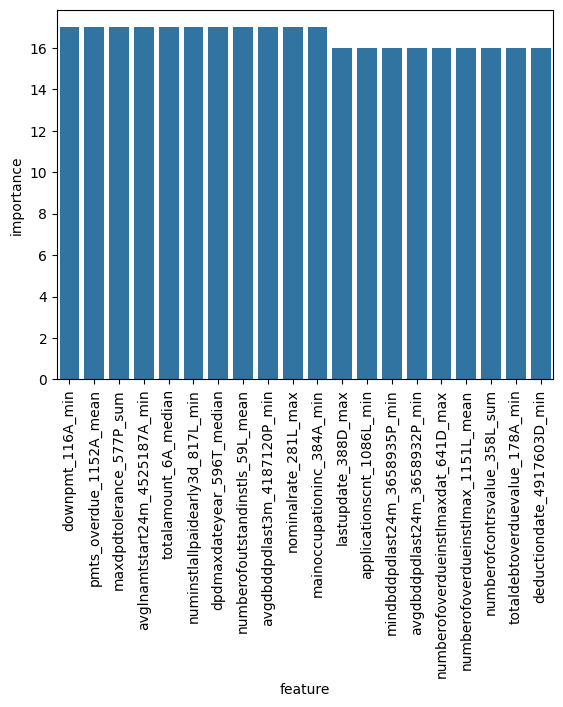

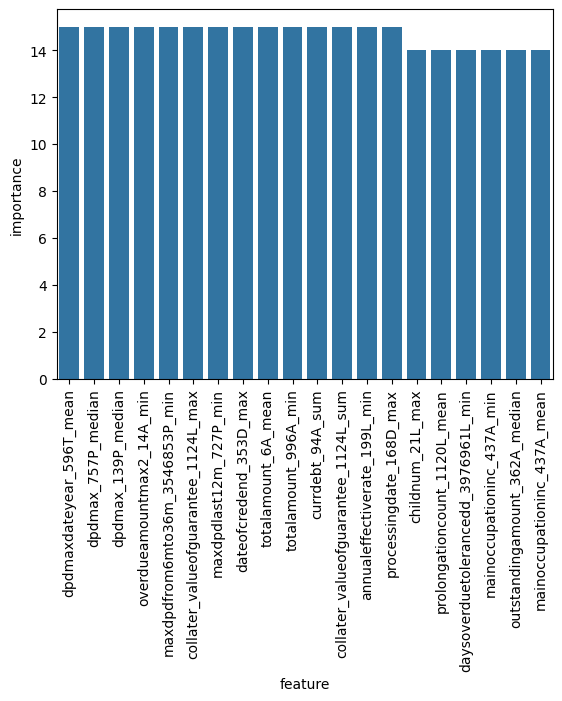

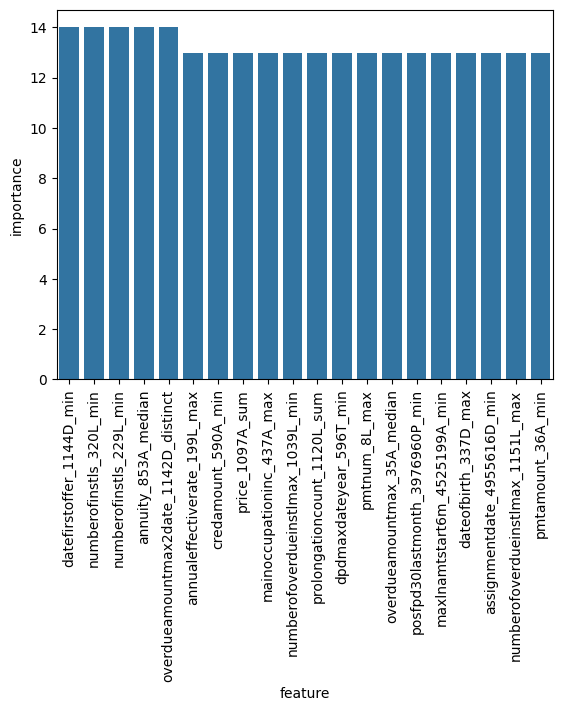

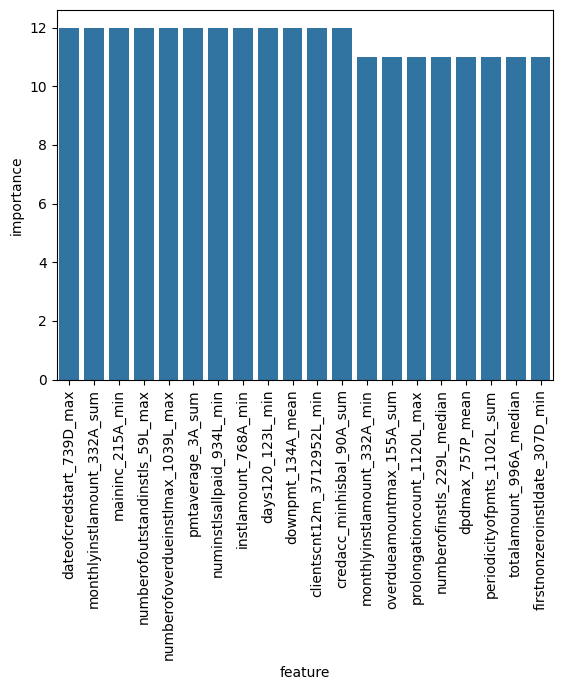

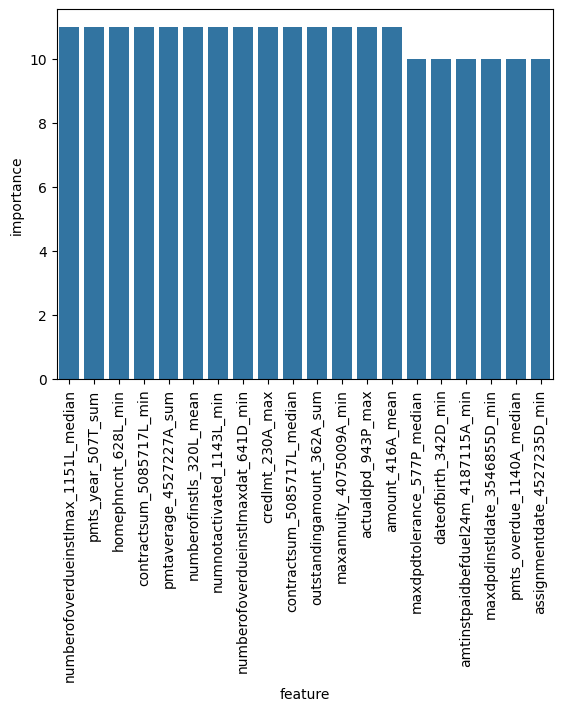

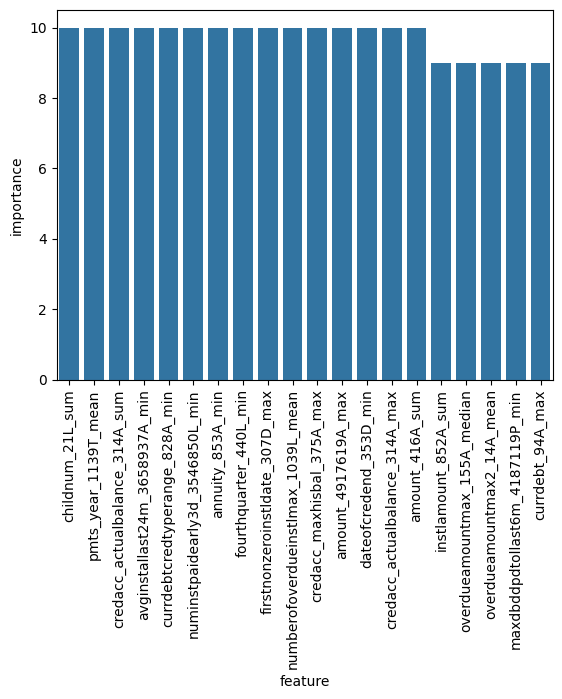

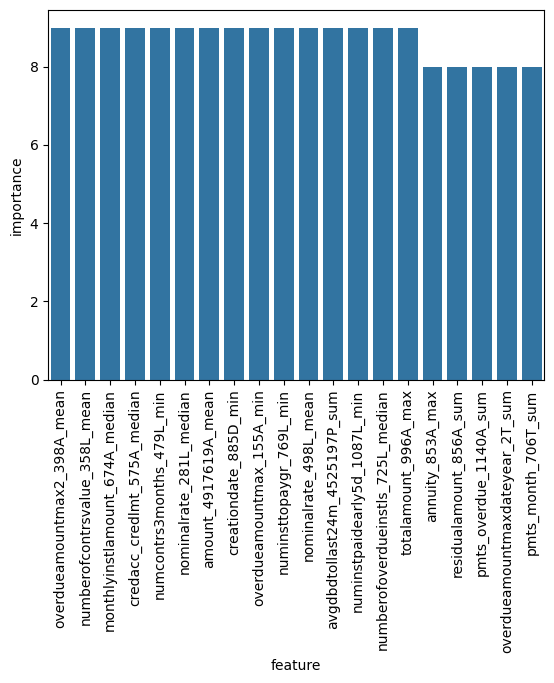

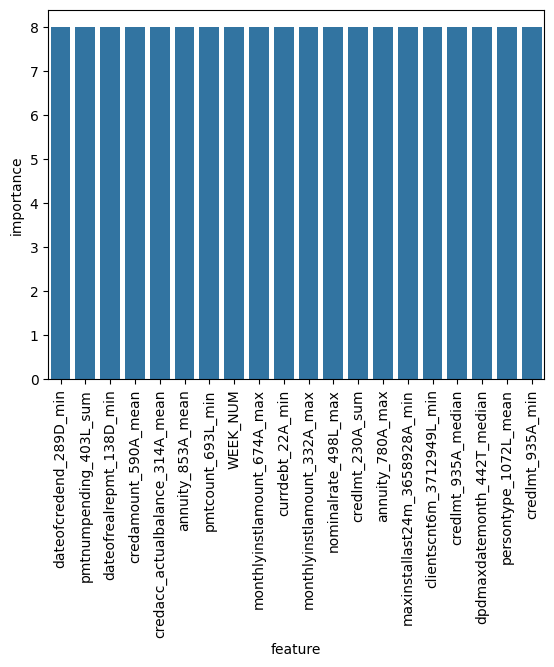

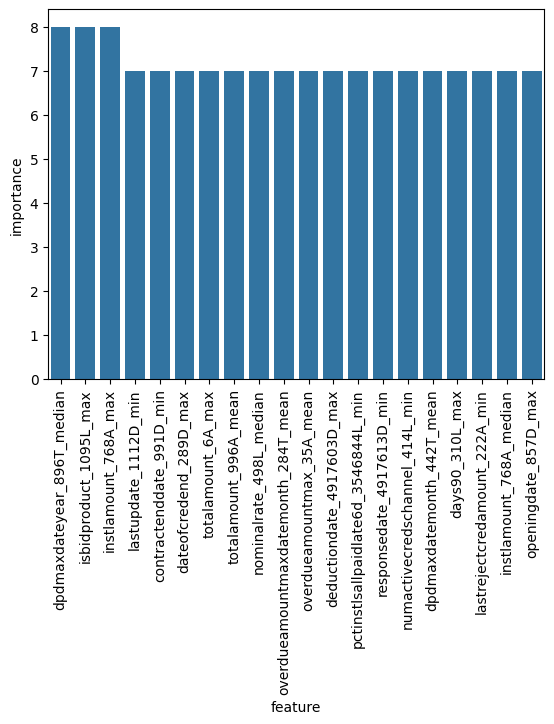

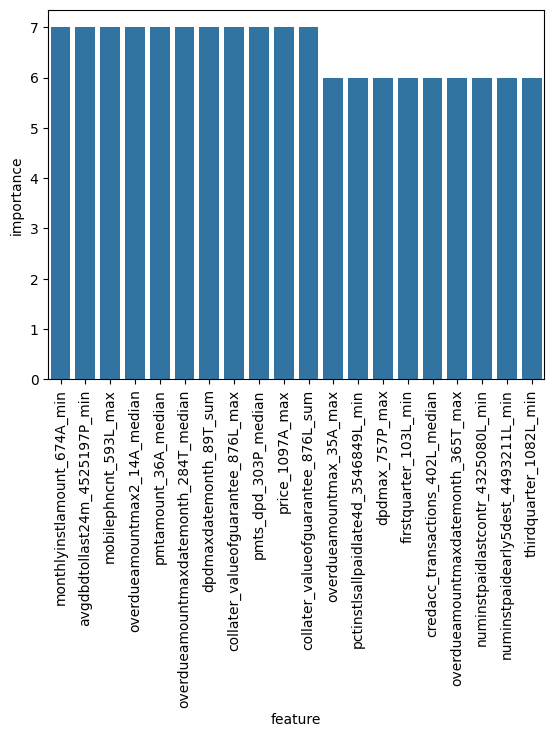

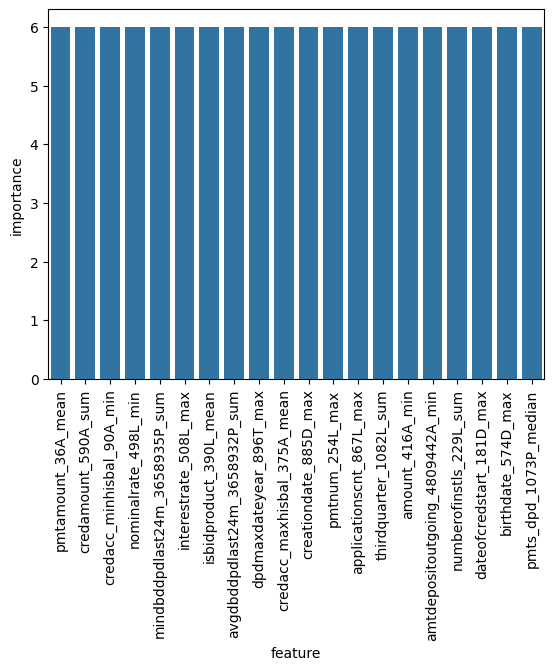

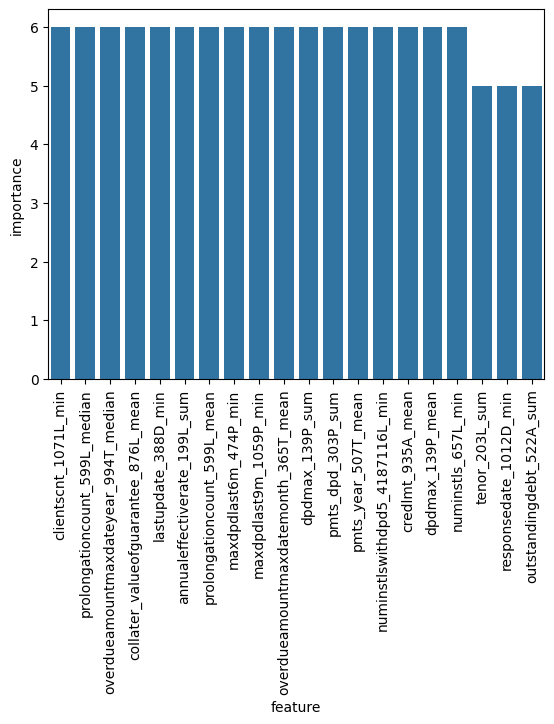

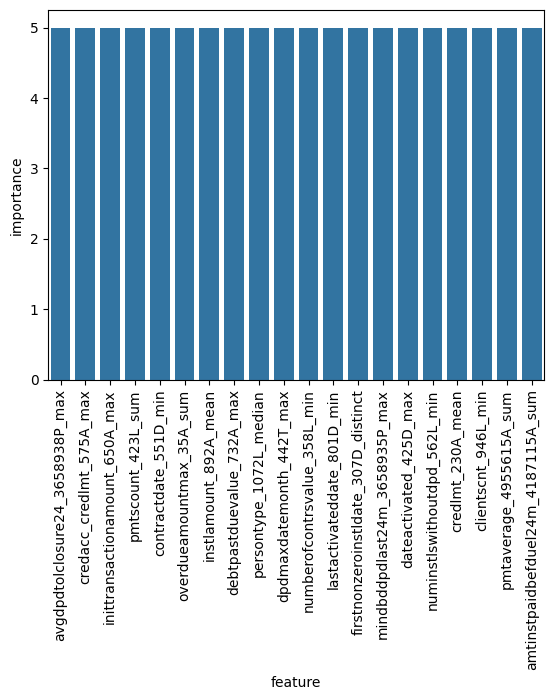

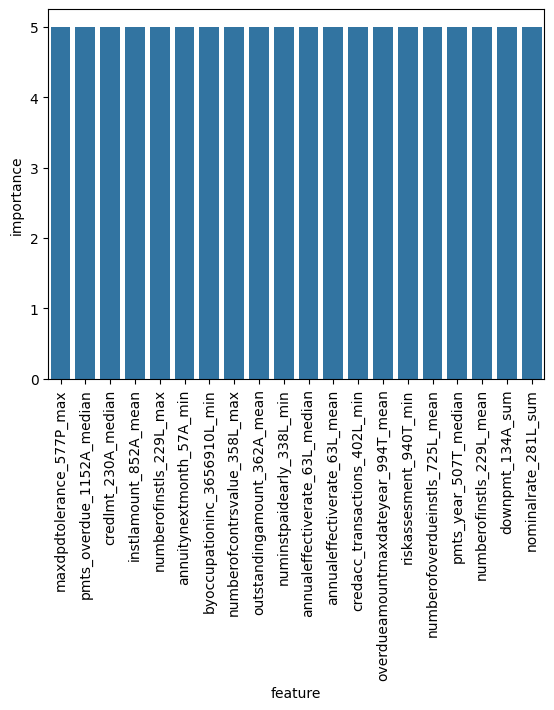

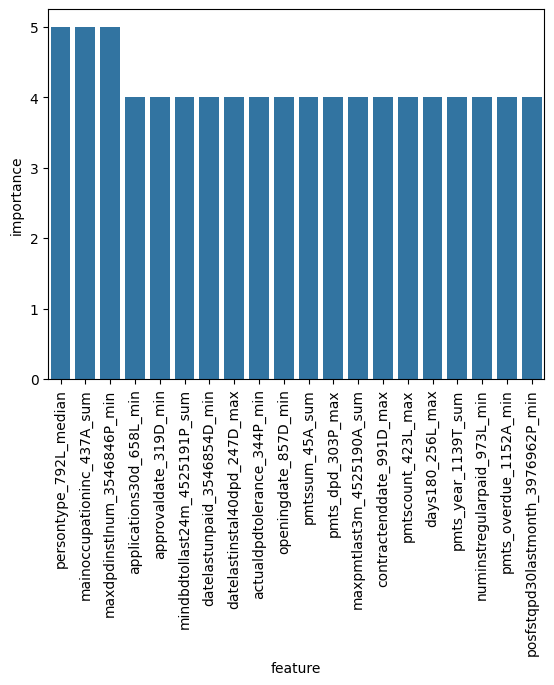

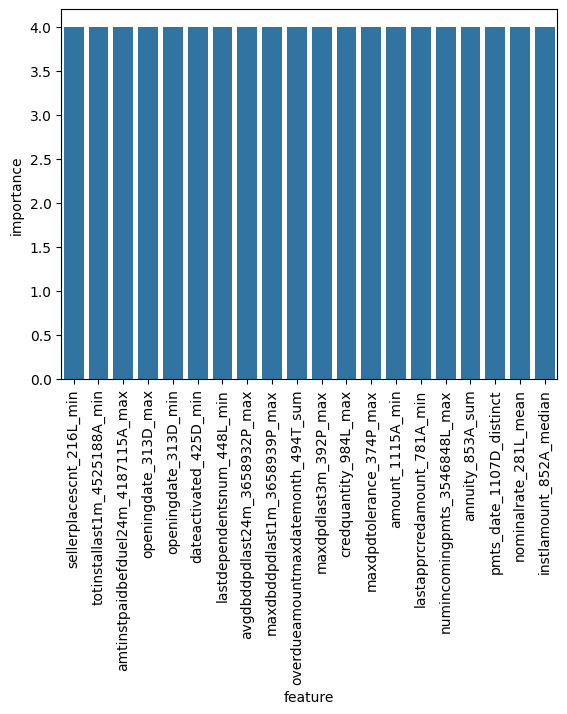

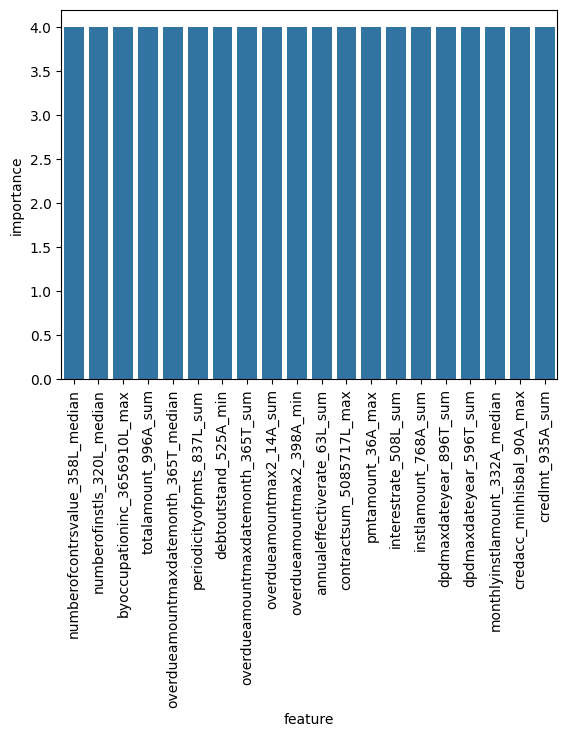

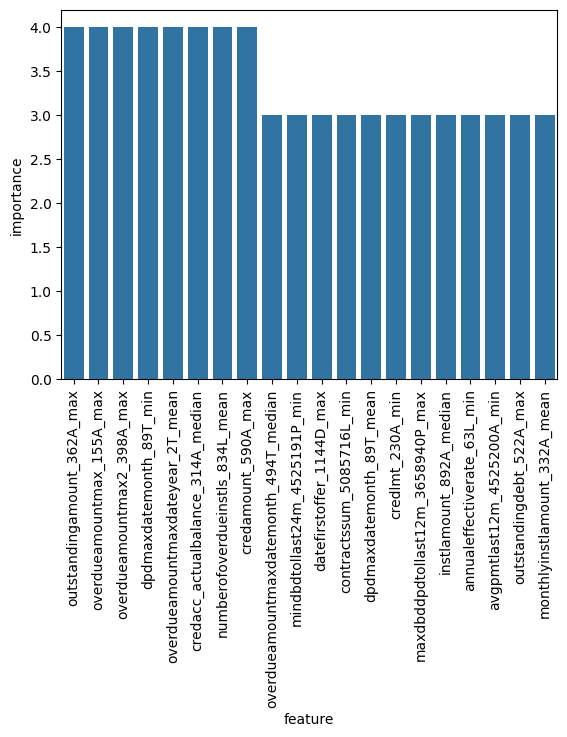

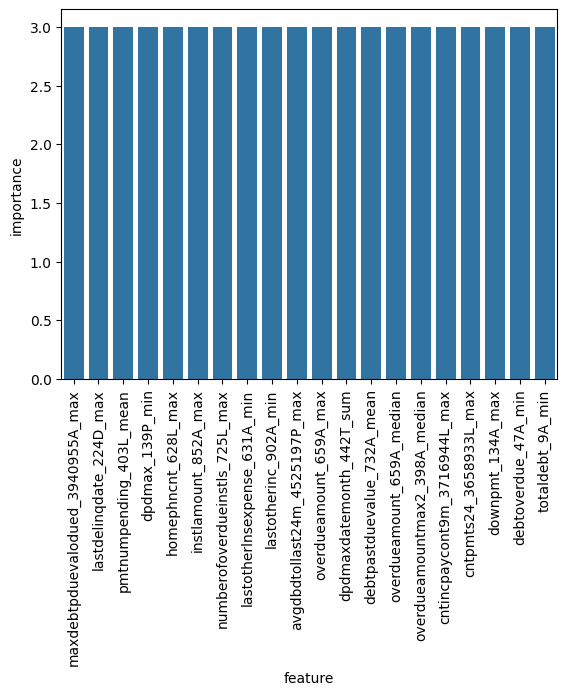

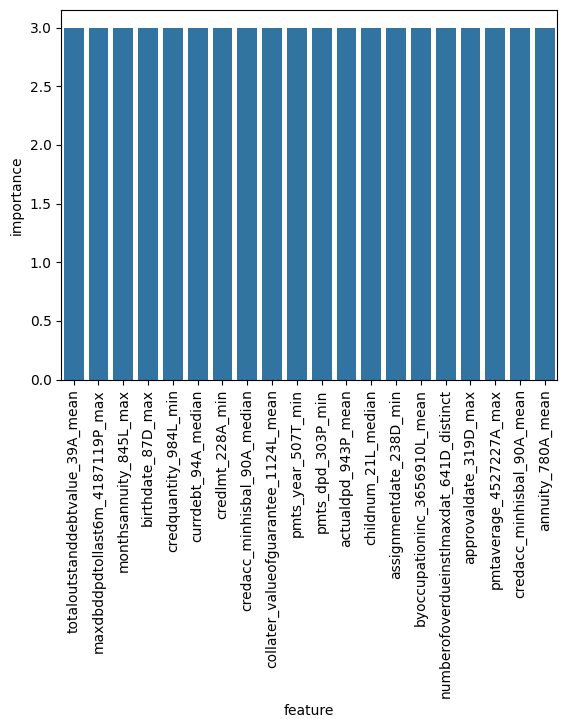

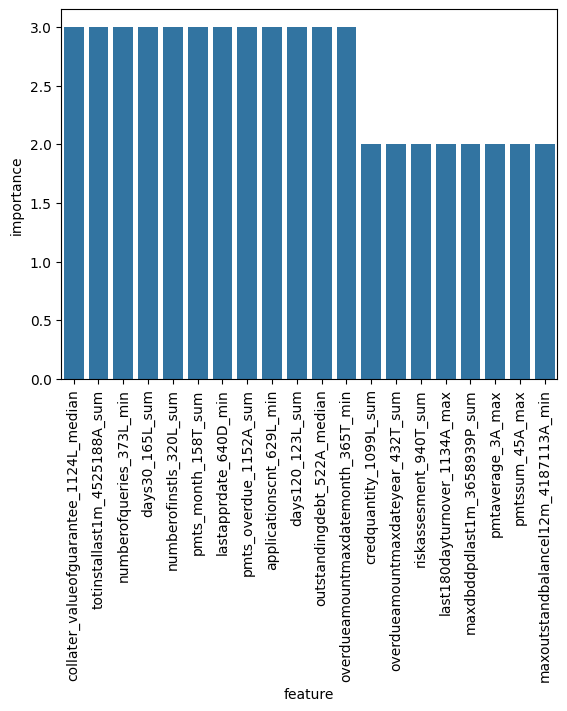

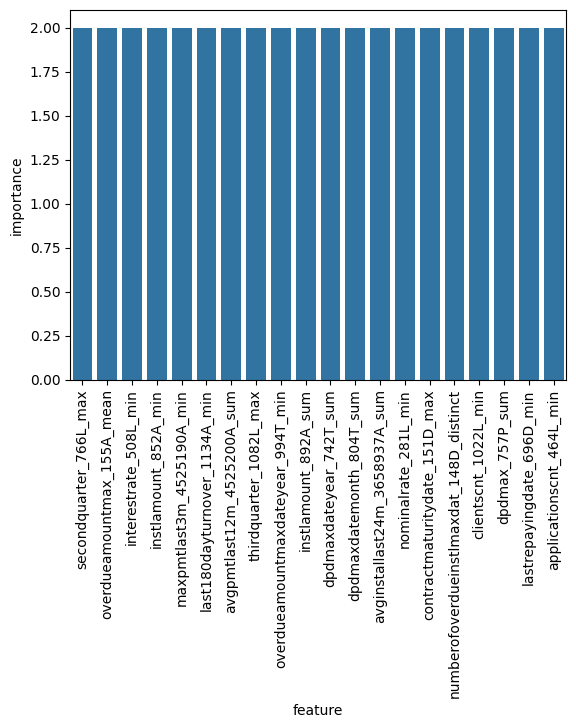

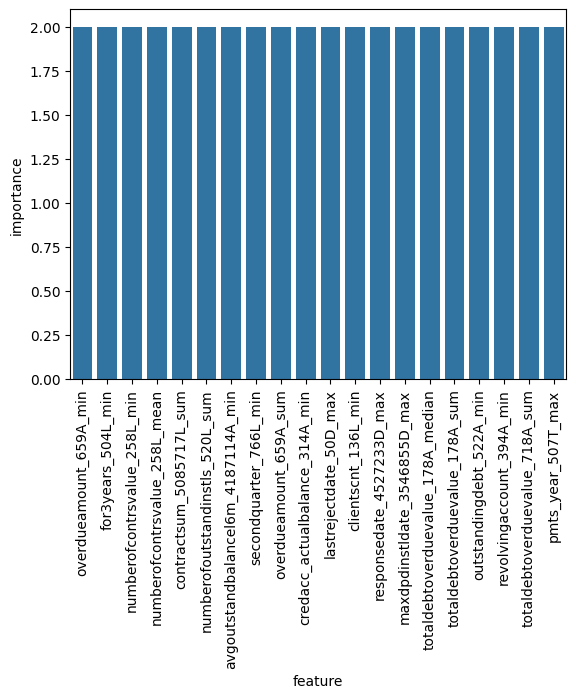

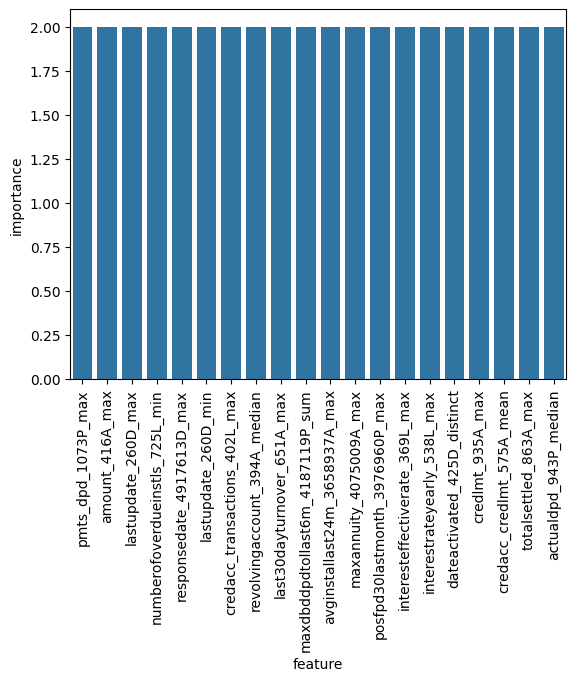

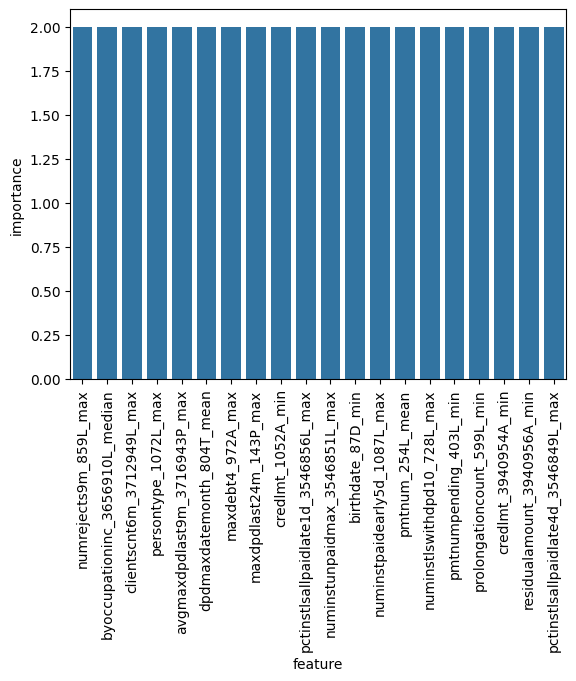

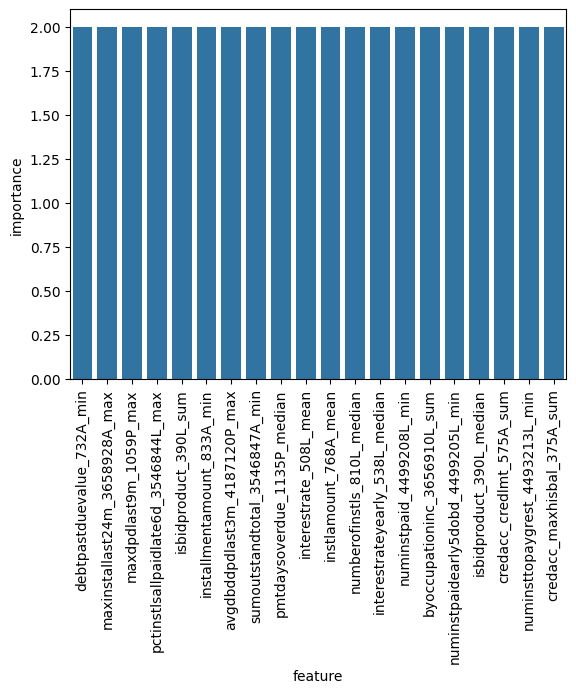

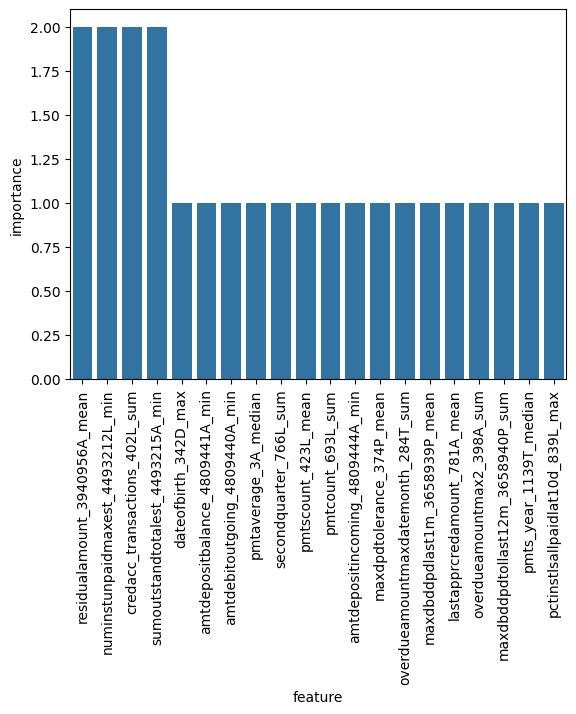

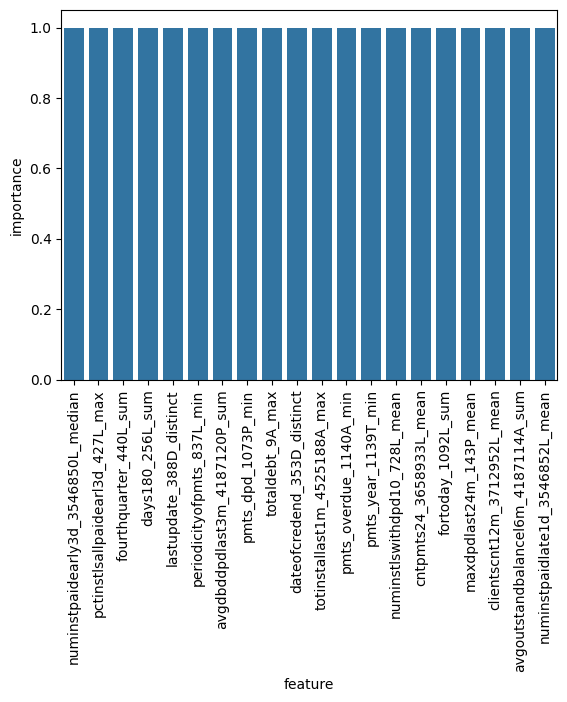

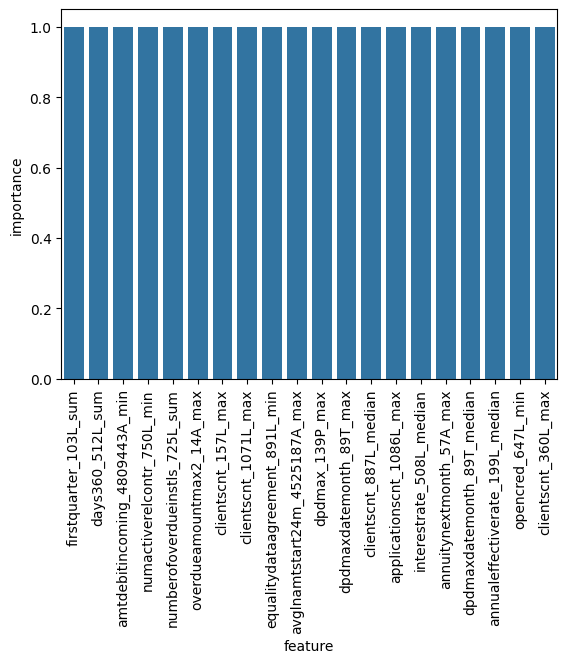

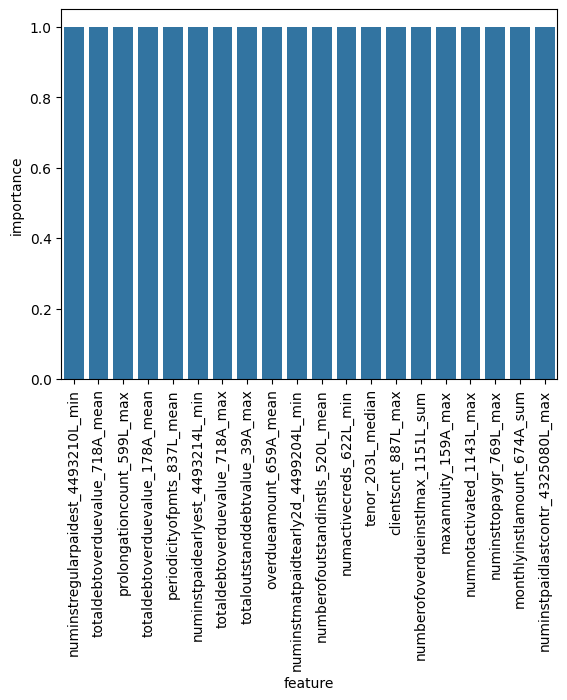

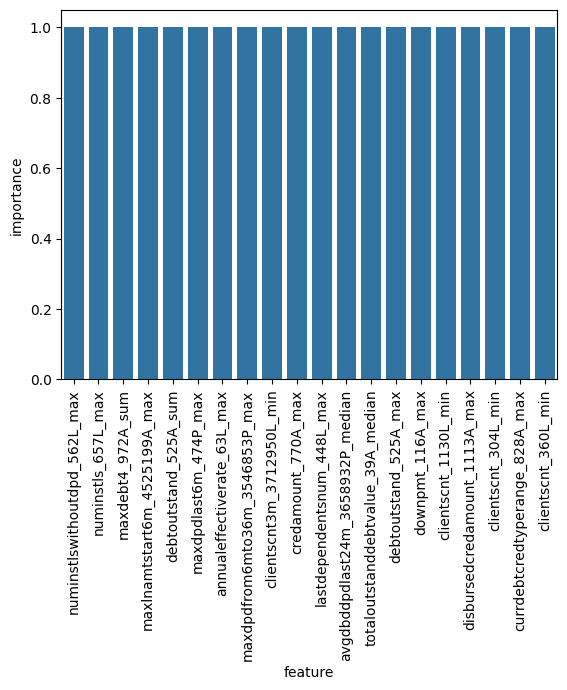

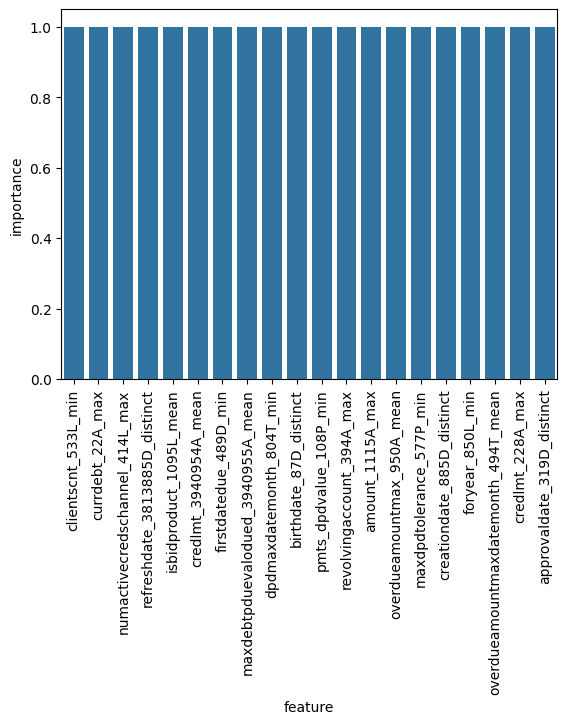

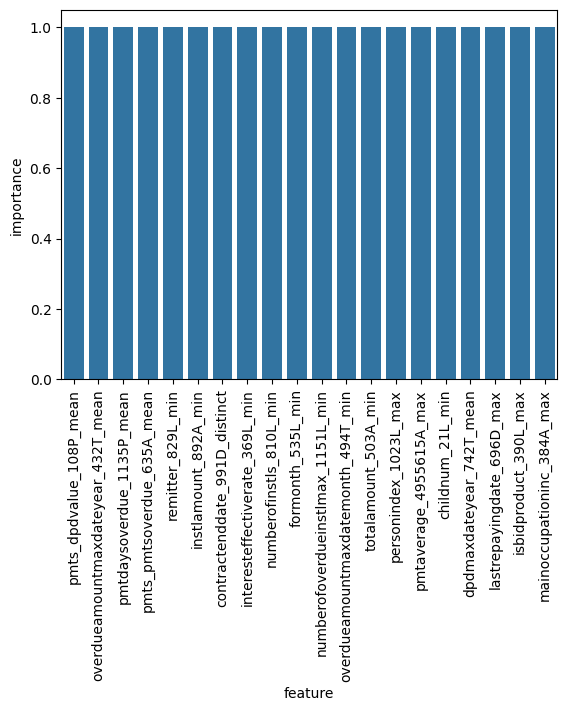

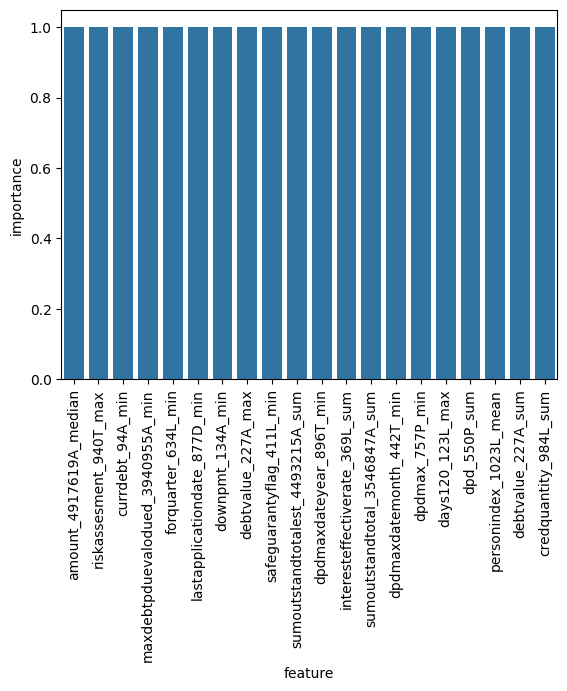

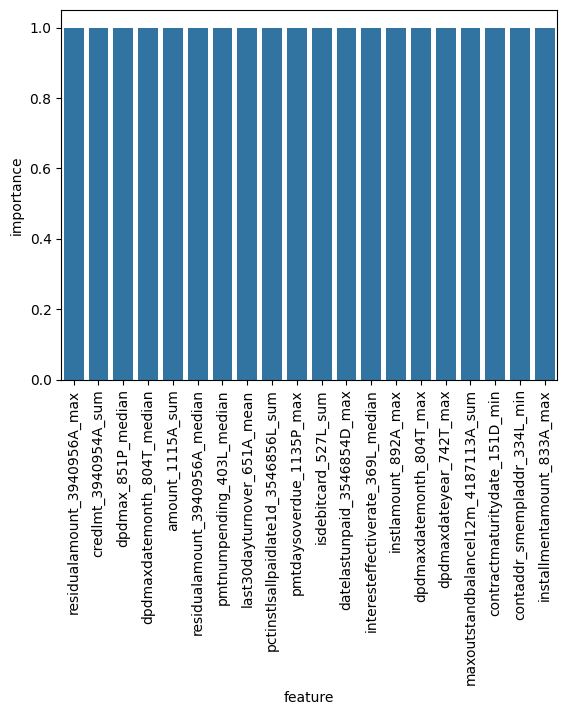

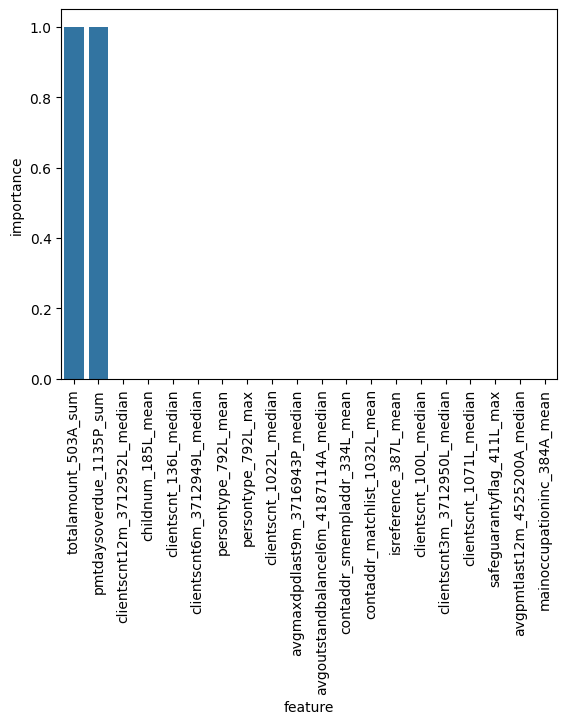

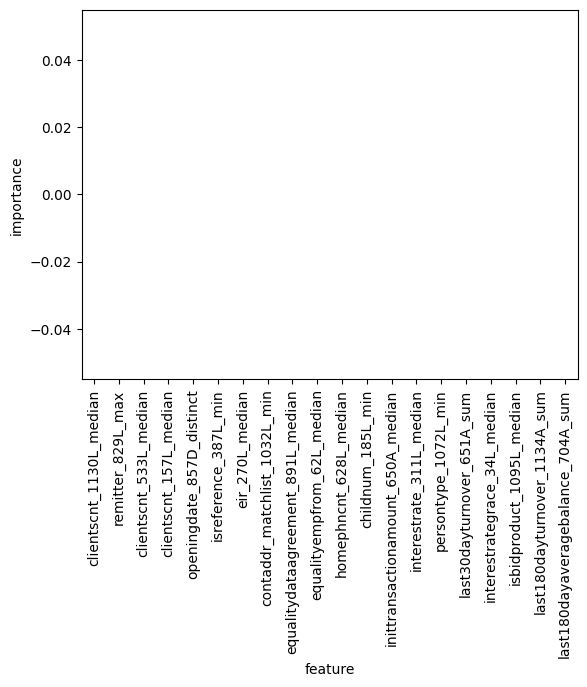

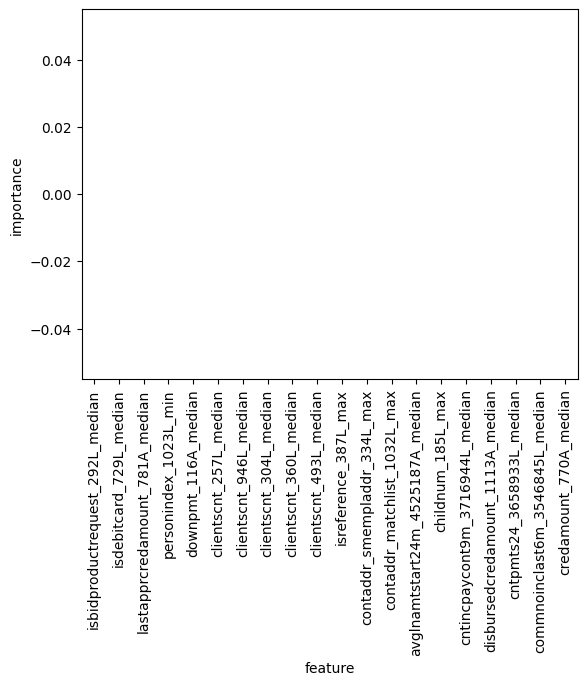

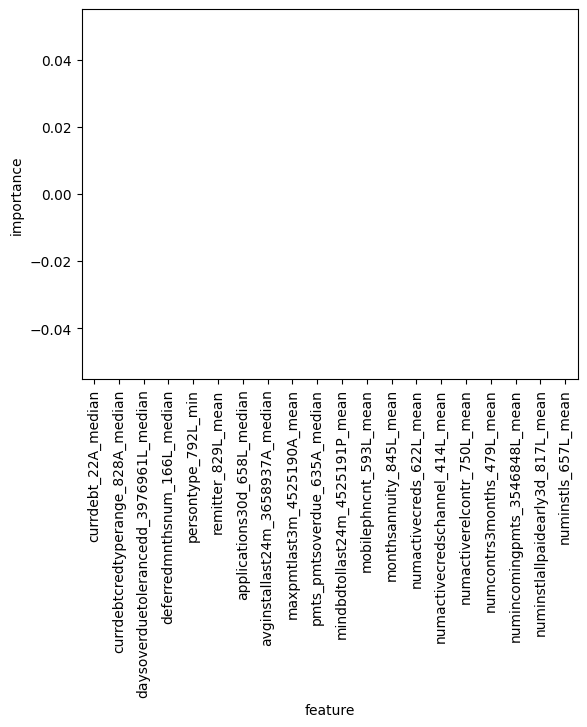

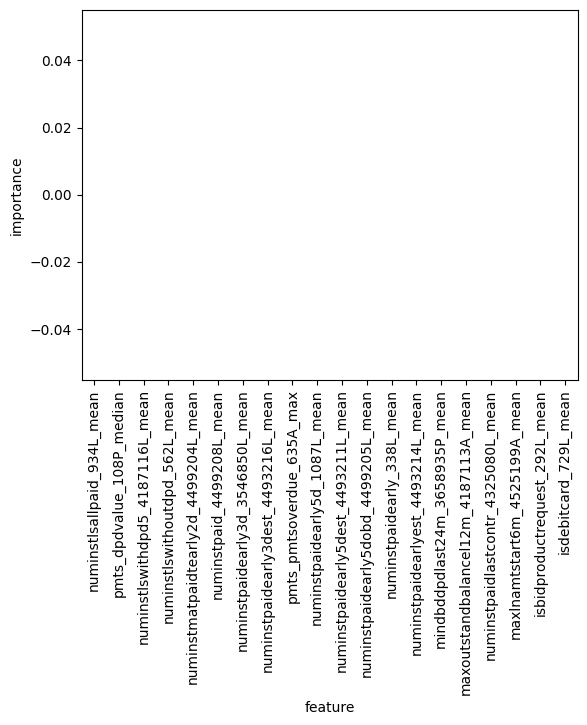

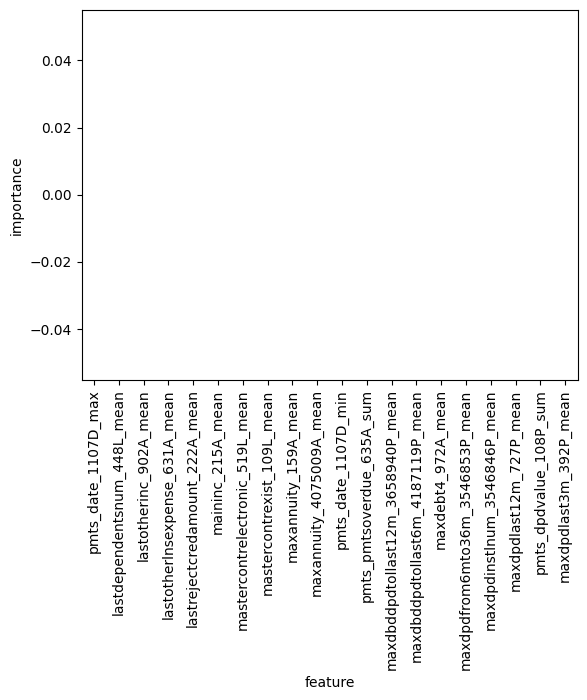

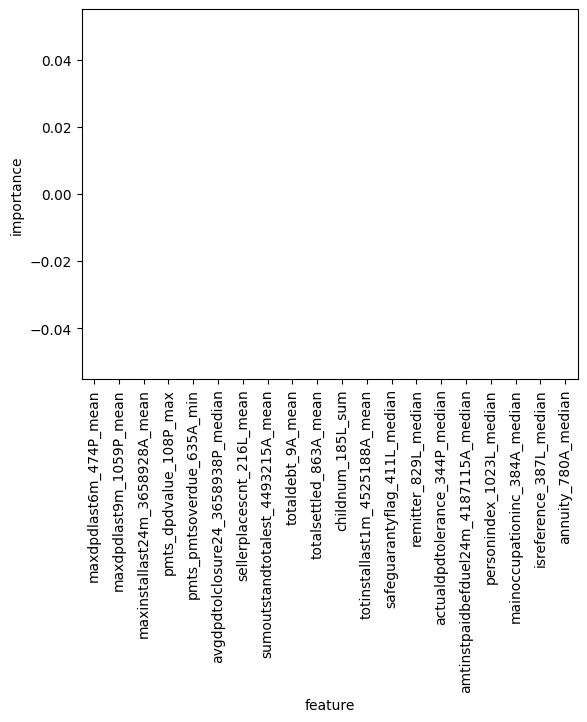

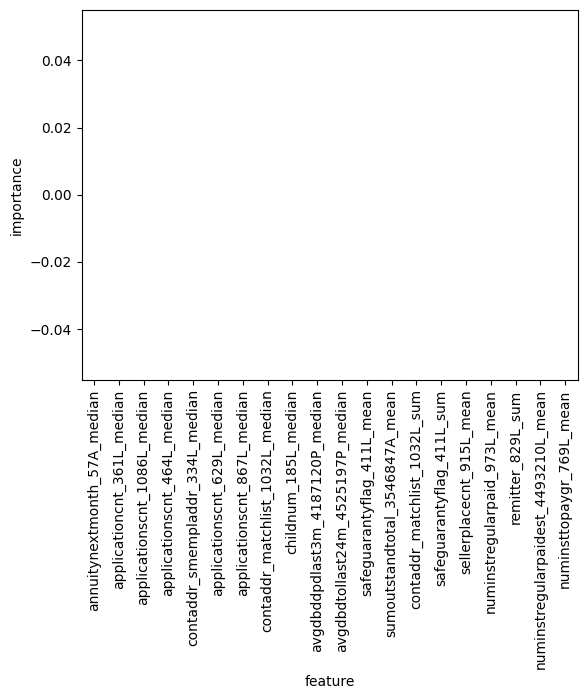

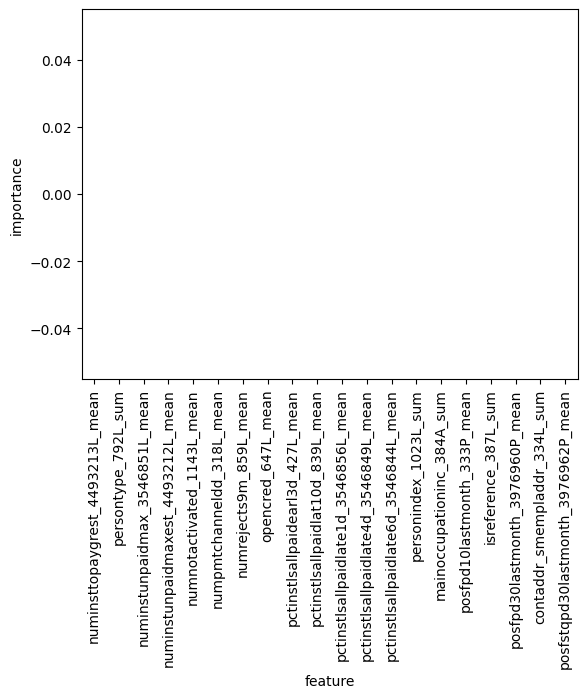

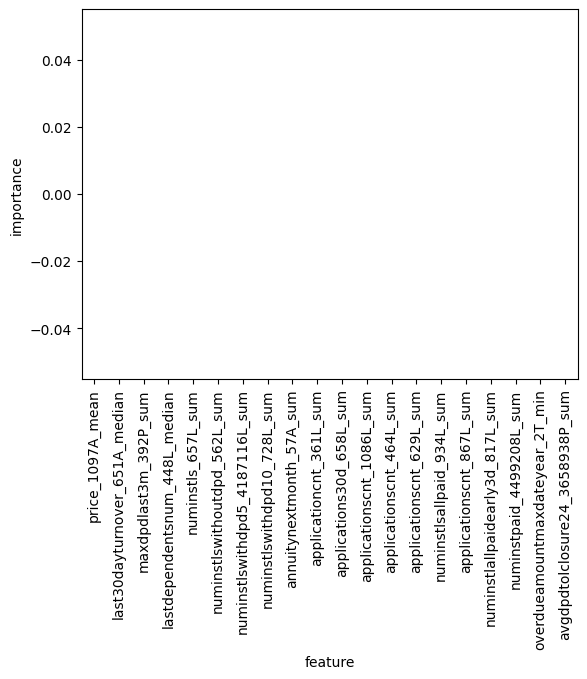

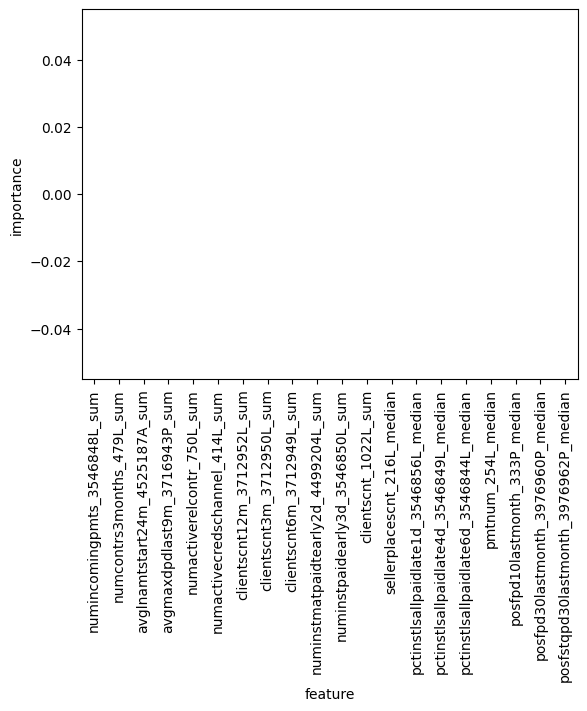

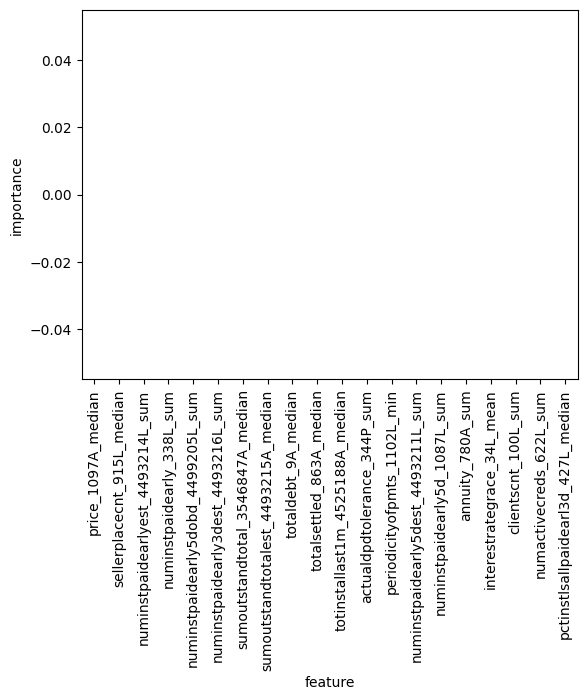

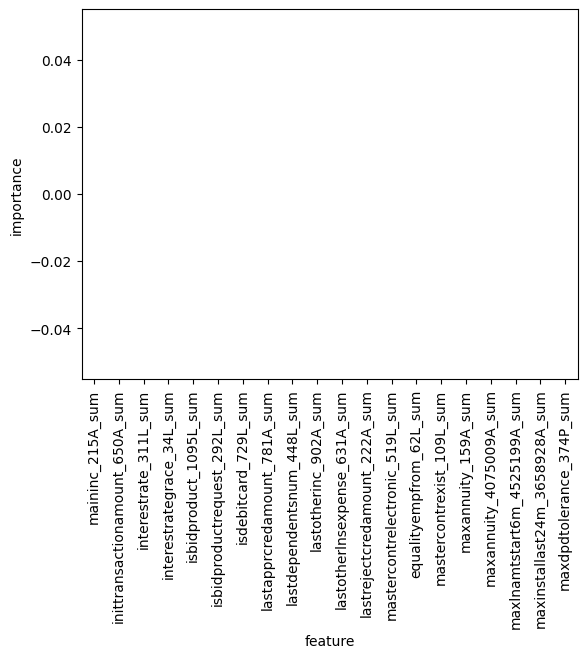

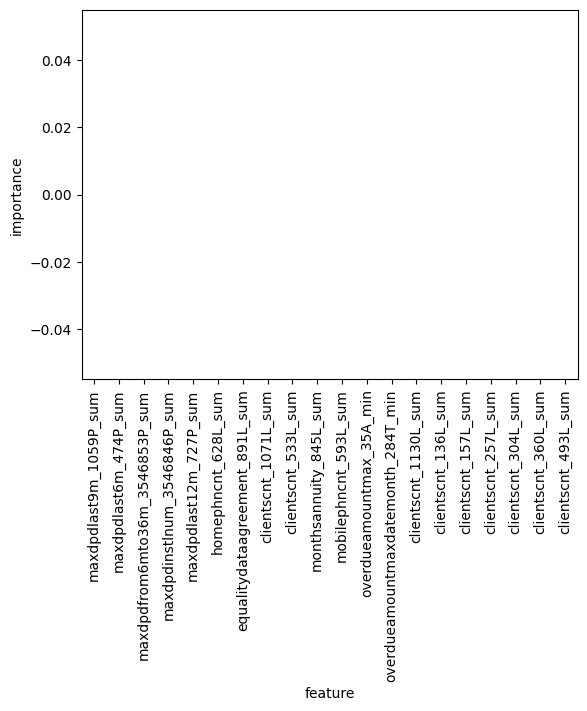

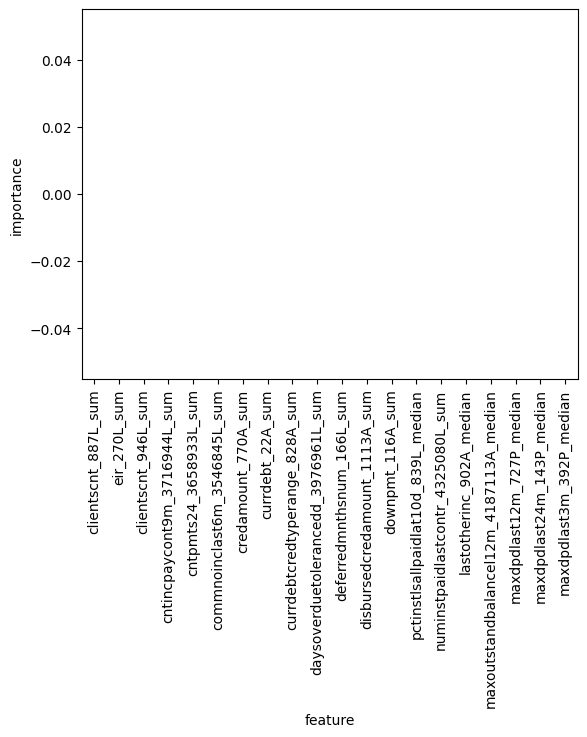

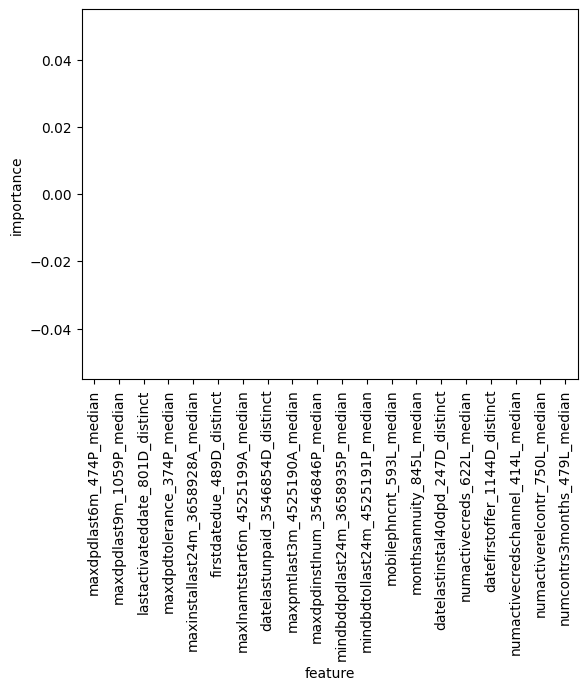

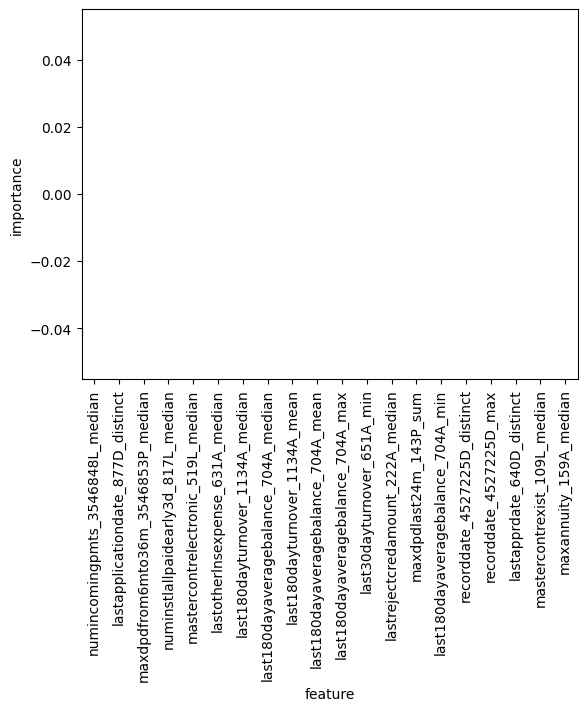

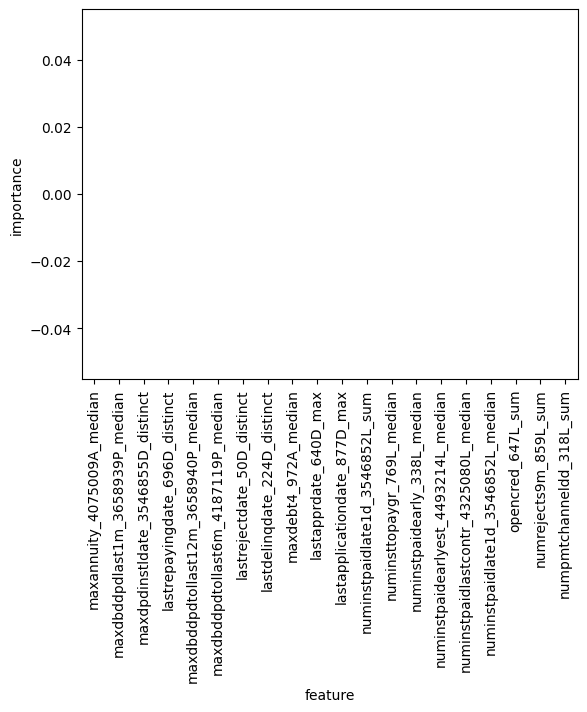

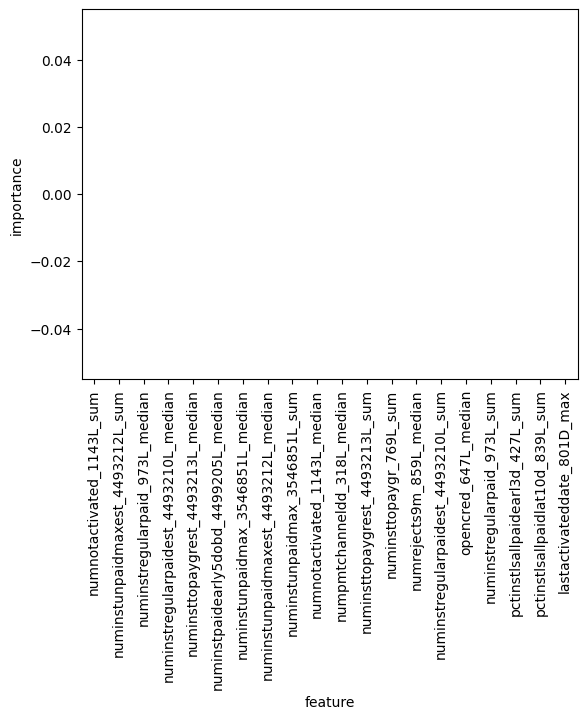

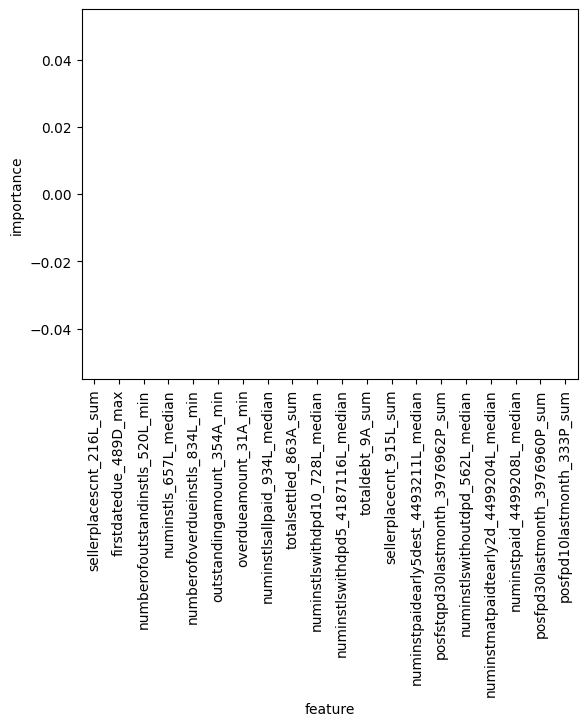

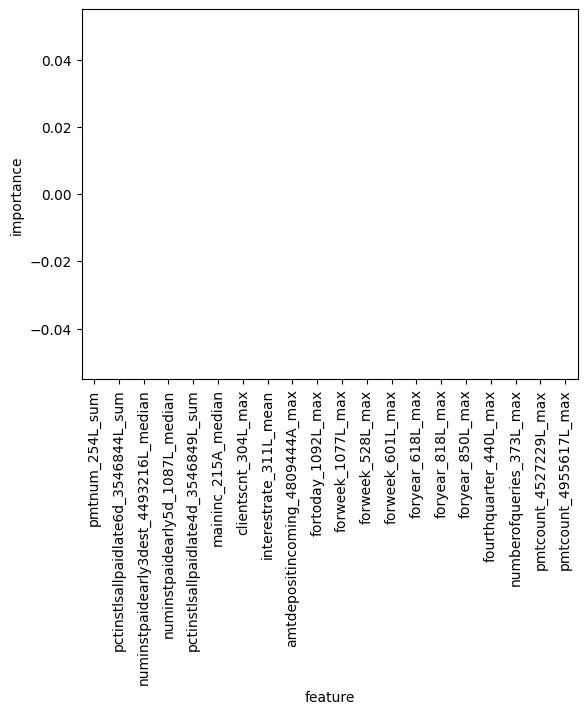

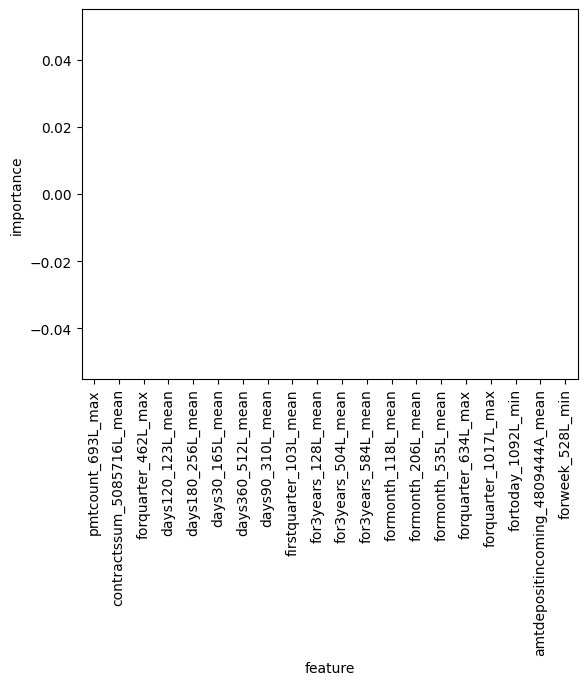

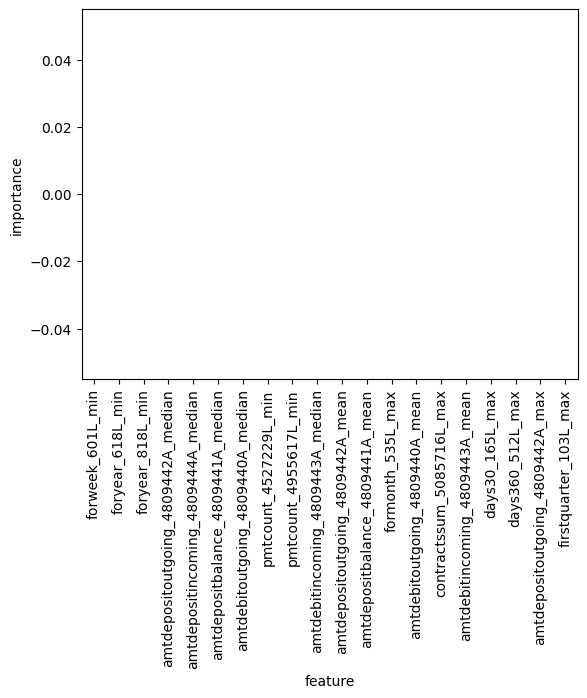

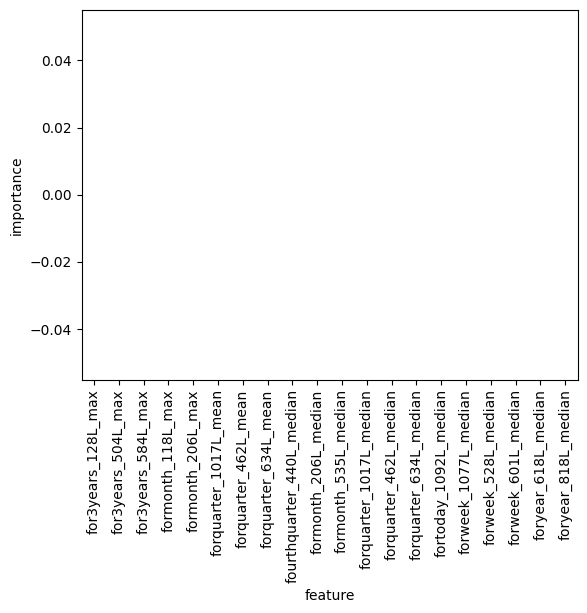

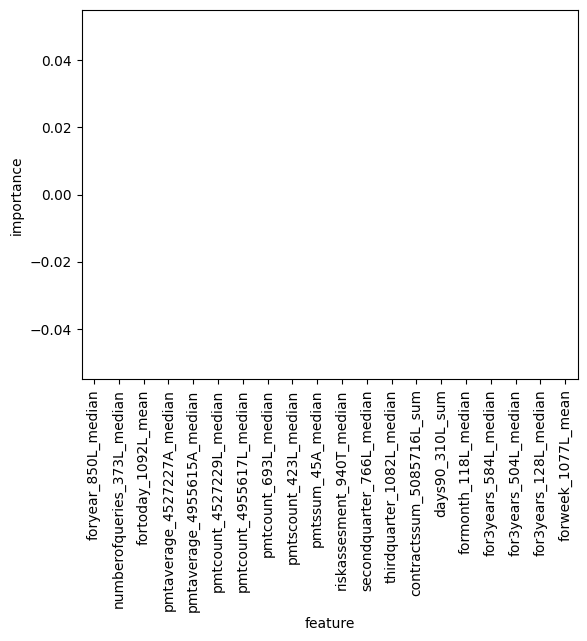

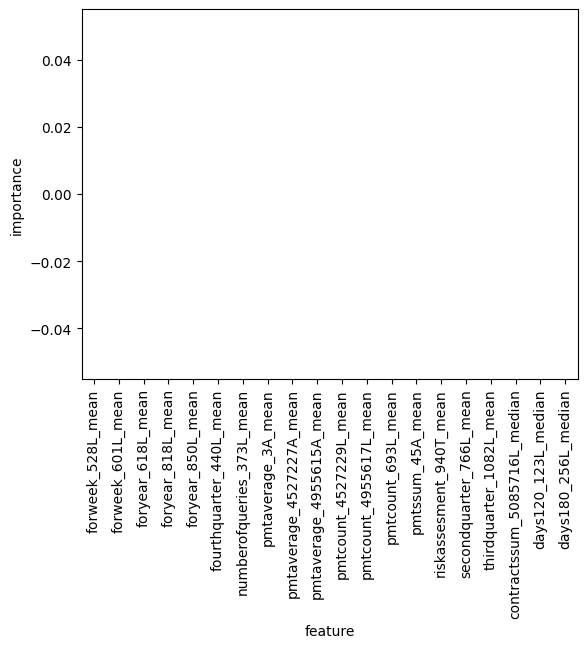

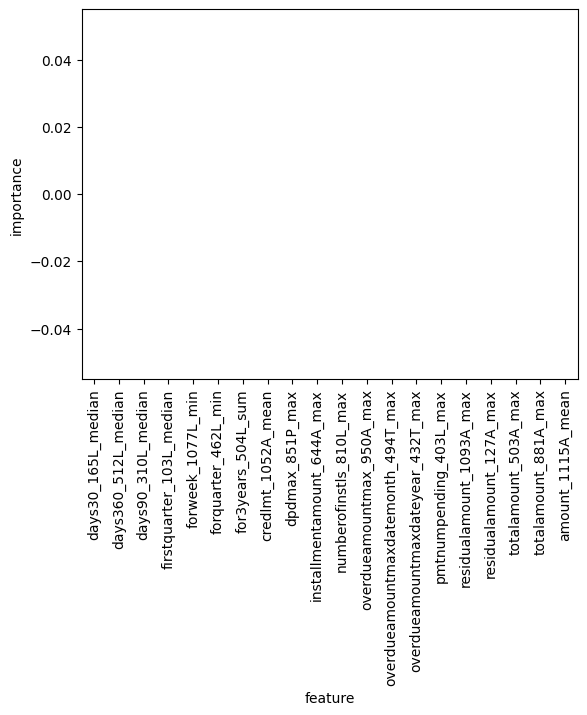

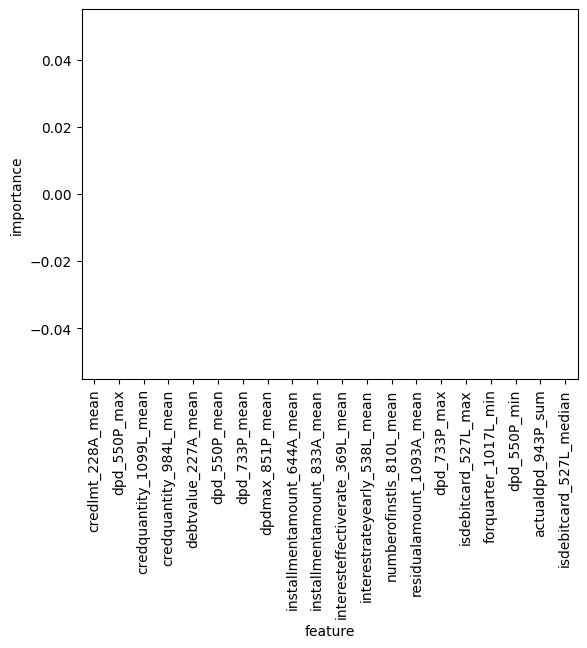

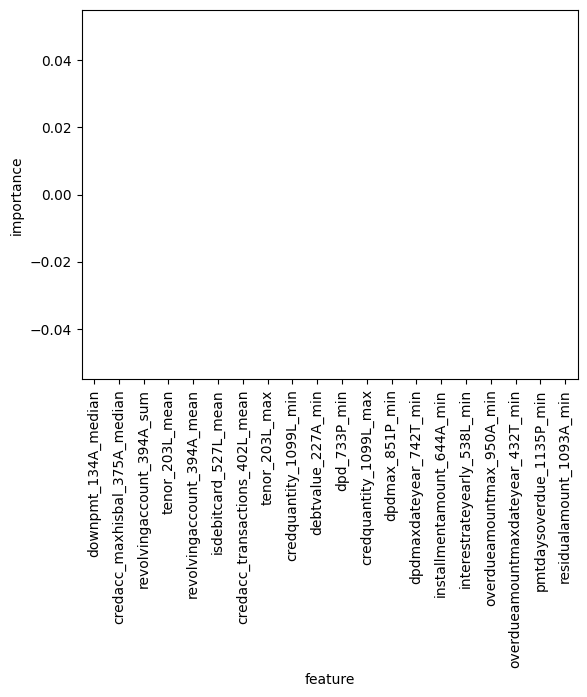

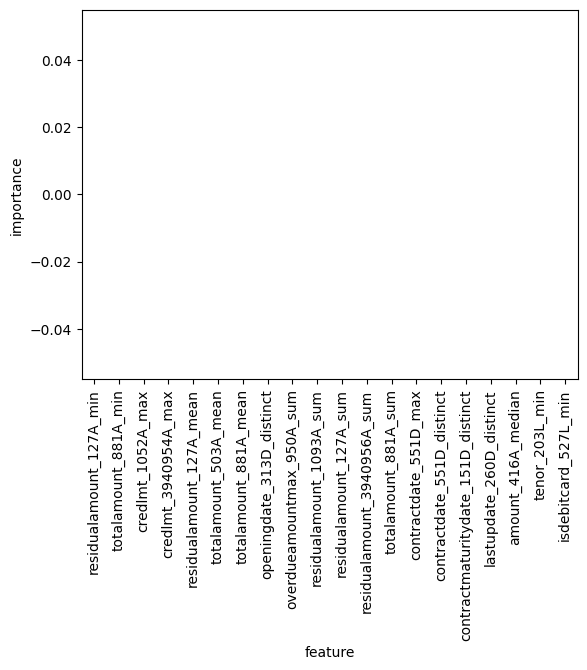

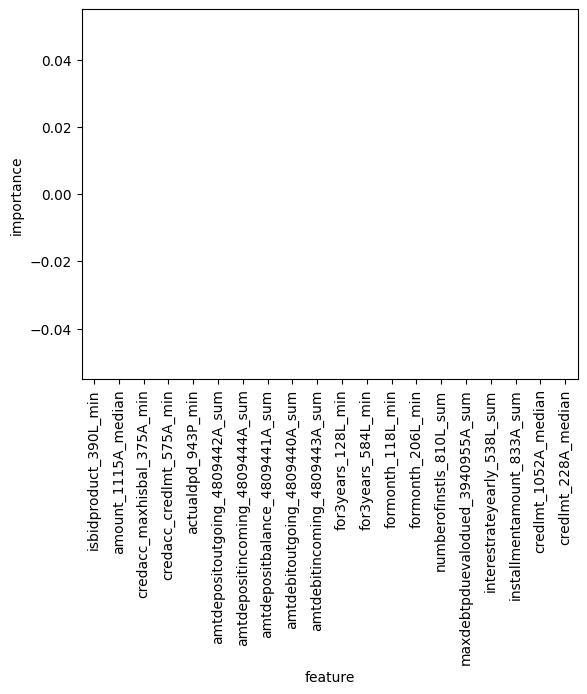

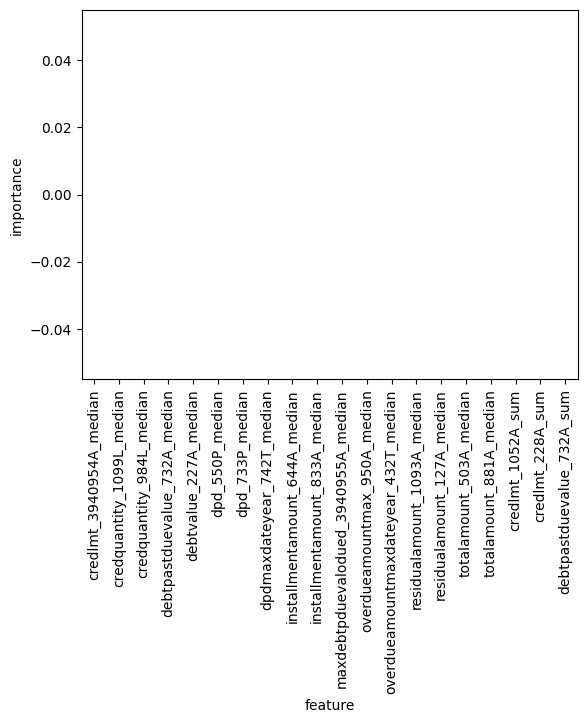

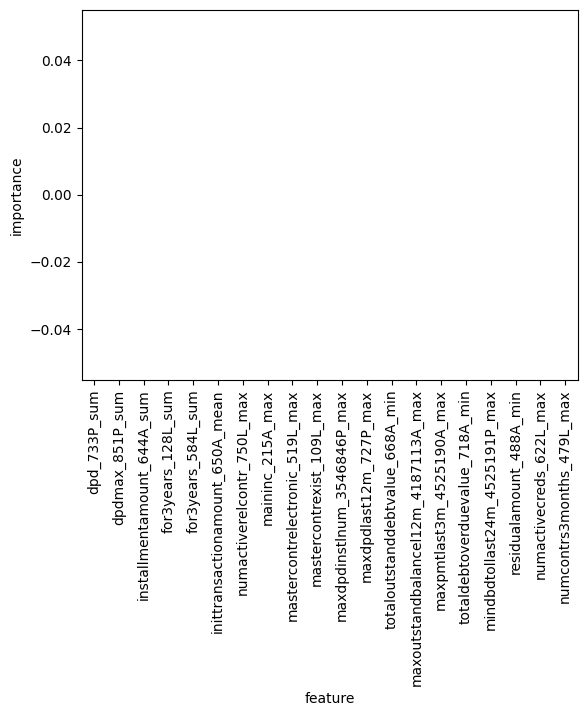

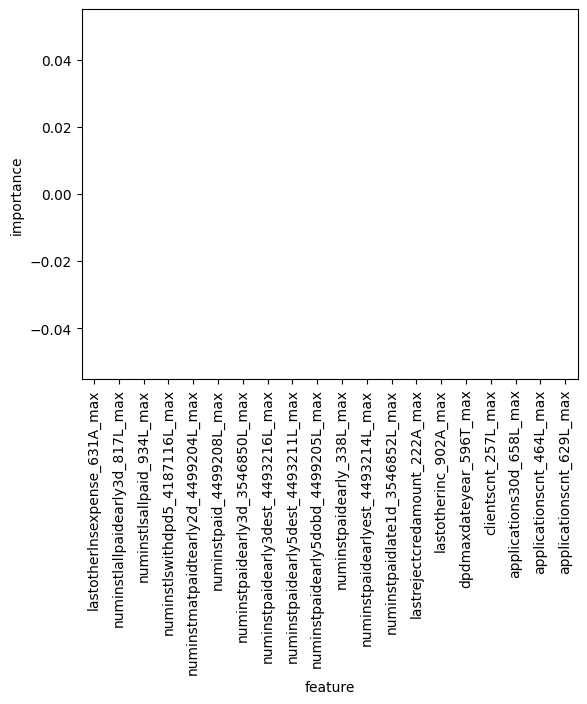

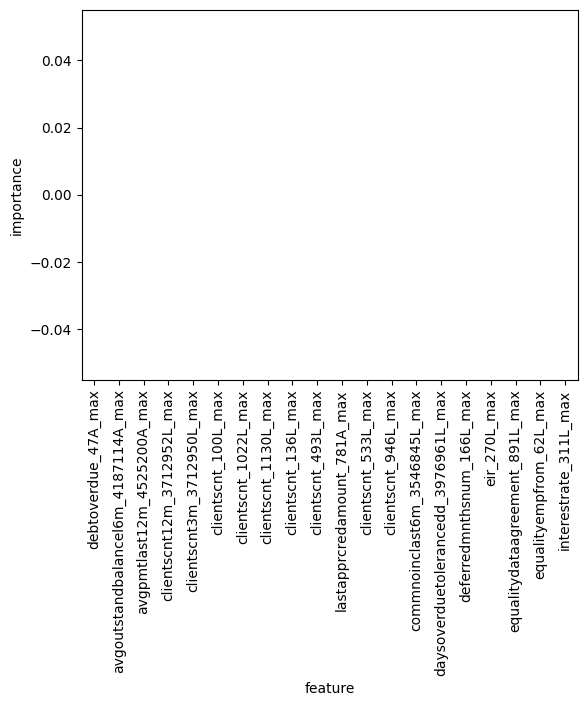

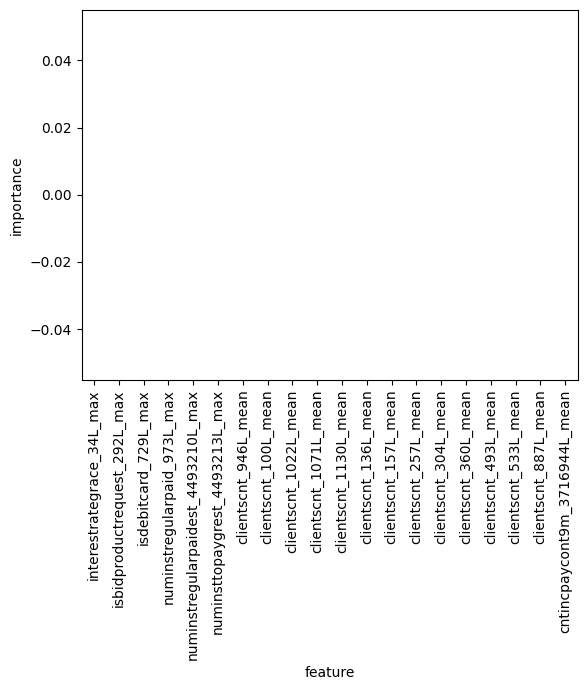

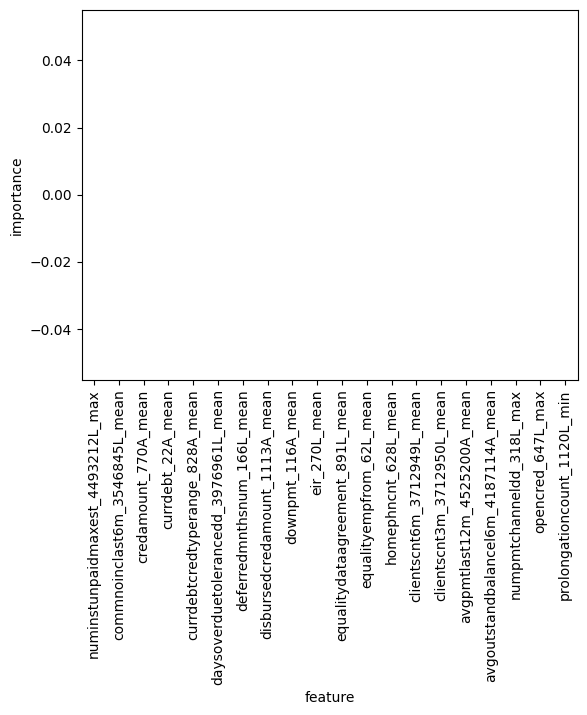

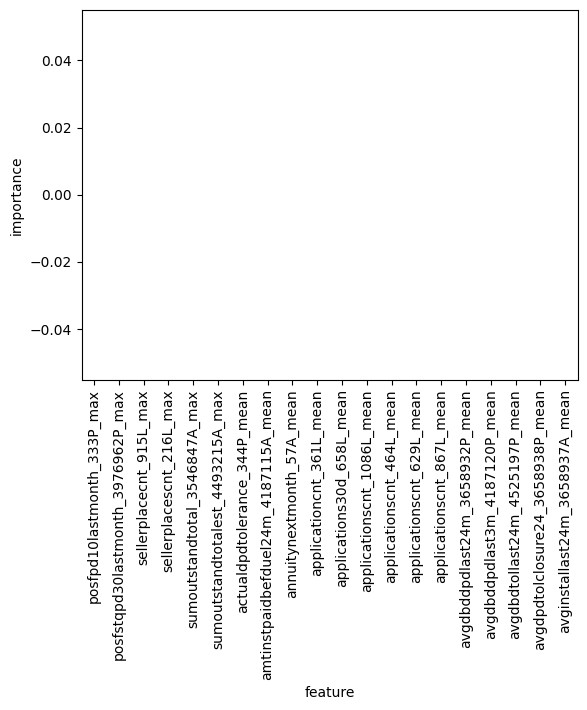

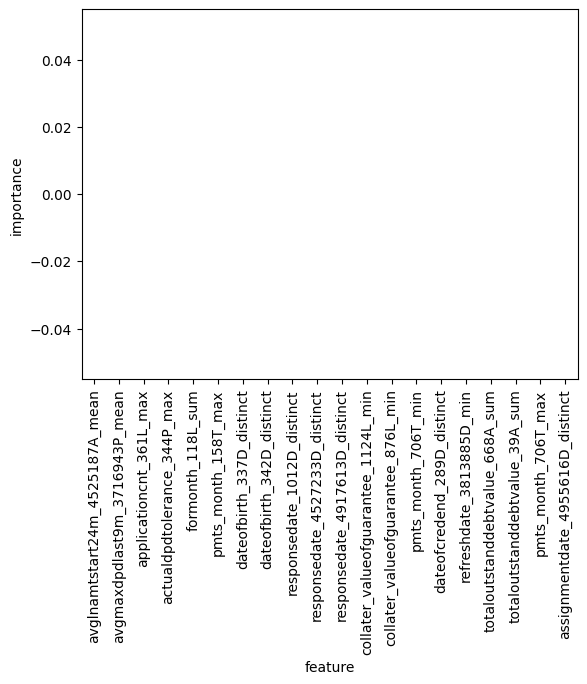

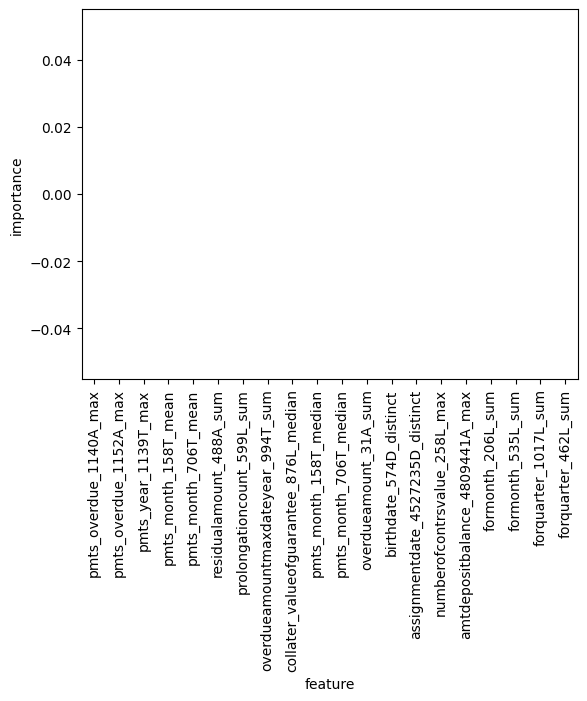

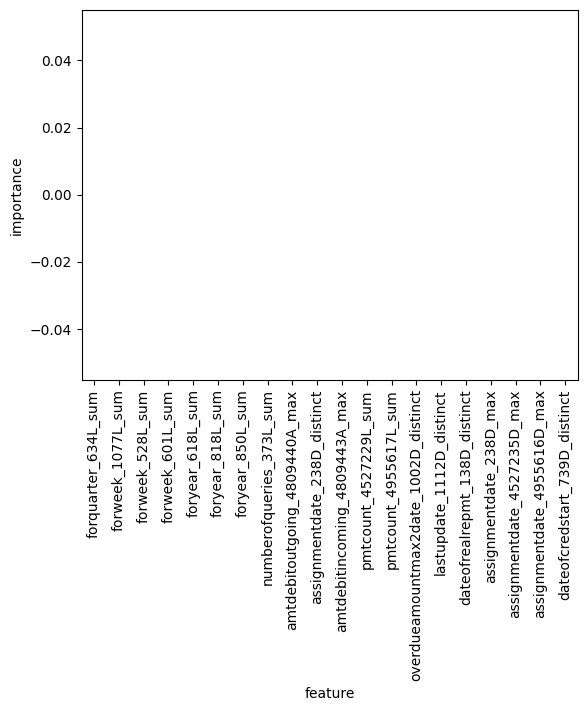

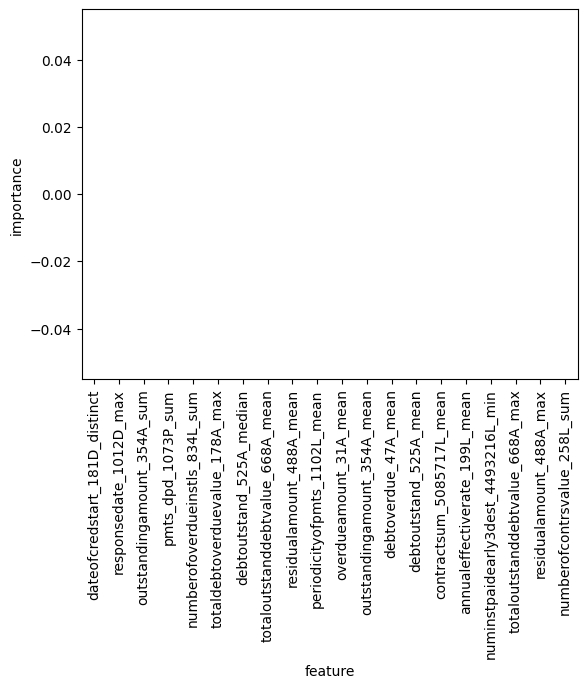

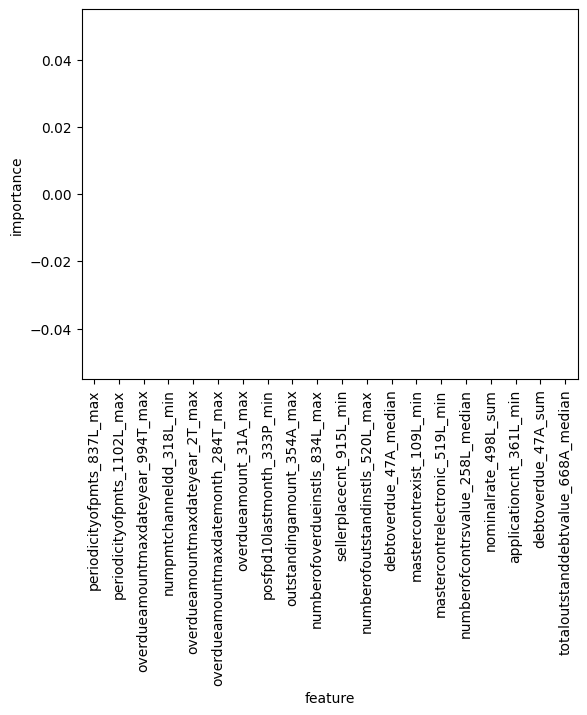

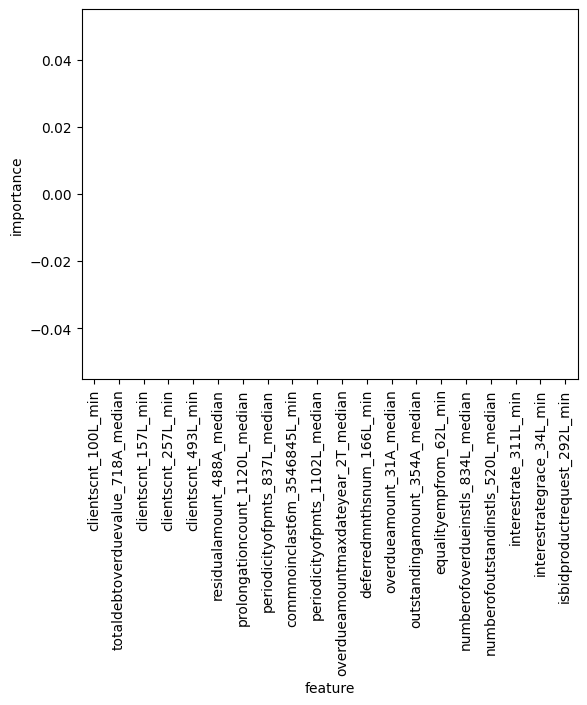

In [30]:
for i in range(len(feat_df) // 20):
    start = i*20
    end = start + 20
    sns.barplot(feat_df.iloc[start:end, :], x='feature', y='importance')
    plt.xticks(rotation=90)

    plt.show()